In [207]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from skspatial.objects import Line, Cylinder
from skspatial.plotting import plot_3d

from numpy.random import rand
from scipy.stats import truncexpon

from scipy.integrate import quad

In [208]:
### USEFULL FUNCTIONS ###

k2E = lambda k:81.8*(k/(2*np.pi))**2
E2k = lambda E:2*np.pi*np.sqrt(E/81.8)

theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))
Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))


### Line parametrization ###
def  line_param(t, p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]
    return np.array([p[:,0] + v[:,0]*t, p[:,1] + v[:,1]*t, p[:,2] + v[:,2]*t]).T

### Line-cylinder intersection with p0 outside ###
def CylLine_inter_fromout(p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    delta[delta<0] = np.nan
    t1c, t2c = (-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)
    t1c[t1c<0] = np.nan
    t2c[t2c<0] = np.nan


    v[:,2][v[:,2]==0] = np.nan
    t1z, t2z = (h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]
    t1z[t1z<0] = np.nan
    t2z[t2z<0] = np.nan

    # check if the plane intersects the cylinder
    x1z = p[:,0] + v[:,0]*t1z
    x2z = p[:,0] + v[:,0]*t2z
    y1z = p[:,1] + v[:,1]*t1z
    y2z = p[:,1] + v[:,1]*t2z

    t1z[(x1z**2 + y1z**2) > r**2] = np.nan
    t2z[(x2z**2 + y2z**2) > r**2] = np.nan

    return np.sort((t1c, t2c, t1z, t2z), axis=0)[:2].T

### Line-cylinder intersection with p0 inside ###
def CylLine_inter_fromin(p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]

    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    delta[delta<0] = np.nan
    t1c = (-b + np.sqrt(delta))/(2*a)
    t1c[t1c<0] = np.nan

    v[:,2][v[:,2]==0] = np.nan
    t1z = (h/2 - p[:,2])/v[:,2]
    t1z[t1z<0] = np.nan
    
    return np.sort((t1c, t1z), axis=0)[0].T

# Monte carlo simulation of inelastic multiple scattering (Cylinder)

# Variables for simulation

## Geometry

In [209]:
#####################
###### Geometry #####
#####################

### Cylinder geometry ###
r = 2 #cm # radius of the cylinder
h = 4 #cm # height of the cylinder

### Experiment geometry ###
d_a2c = 100 #cm

### "detector" apertures
dtheta = 0.01
dphi = 0.01
domega = .1

## Scattering lenghts

In [210]:
##############################
##### Scattering lenghts #####
##############################

mu_s = .7 #cm^-1
mu_abs = 0.0 #cm^-1

## Montecarlo reps

In [328]:
###############################
##### # of Montecrlo reps #####
###############################
N=1000000

## Scattering geometry

In [215]:
####################################
##### Scattering configuration #####
####################################

### Incident energy ###
ki = 5.8 #A^-1
Ei = k2E(ki) #meV

### Final energy ###
kf = 5.8
Ef = k2E(kf)
omega = Ei - Ef

### Scattering angle / Q ###
theta = np.deg2rad(10)
Q = theta2Q(omega, ki, theta)

## S(Q, $\omega$)

In [222]:
##################
##### S(Q,w) #####
##################

# LOAD S(Q,E)
S_mesh = np.load('./data_Sq/Sqw_test/S_mesh.npy')
Q_mesh = np.load('./data_Sq/Sqw_test/Q_mesh.npy')
omega_mesh = np.load('./data_Sq/Sqw_test/omega_mesh.npy')

# Usefull vectors
omega_vec = omega_mesh[0,:]
Q_vec = Q_mesh[:,0]
dQ_vec = Q_vec[1]-Q_vec[0]
domega_vec = omega_vec[1]-omega_vec[0]

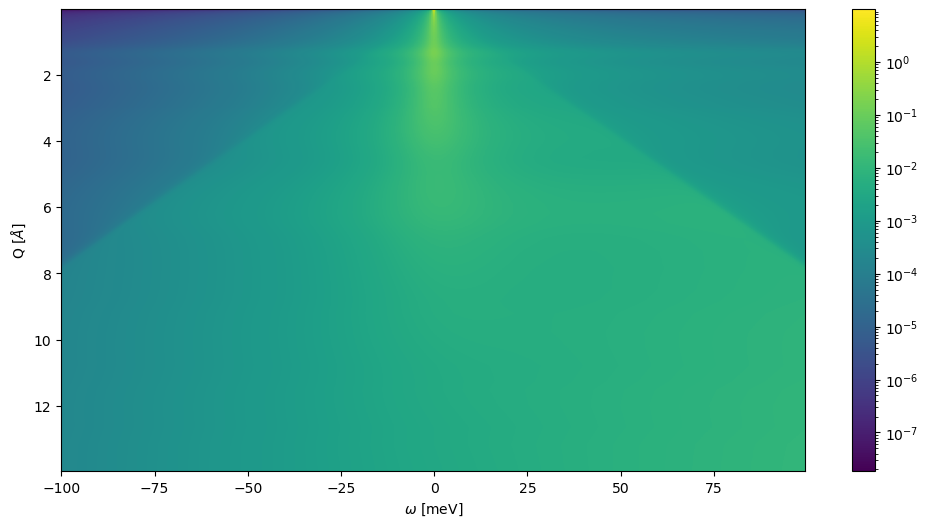

In [232]:
# Useful object for plots
S_imshow_extent = [omega_vec.min(),omega_vec.max(),Q_vec.max(),Q_vec.min()]

# plot
plt.figure(figsize=(12,6))
plt.imshow(S_mesh, norm='log', cmap='viridis', aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

# Initial calculations

## Dynamc range for direct scattering event
$$
Q = ki \sqrt{2-\frac{\omega}{E_i}-2*\sqrt{1-\frac{\omega}{E_i}}\cos(\theta)}

In [329]:
###############################################
##### Dynamic range for direct scattering #####
###############################################

Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
# slower version: Q_lowlim = lambda ki: np.concatenate([ki * np.sqrt(2 - omega_vec[omega_vec<=k2E(ki)]/k2E(ki) - 2*np.sqrt(1 - omega_vec[omega_vec<=k2E(ki)]/k2E(ki))), np.zeros(omega_vec[omega_vec>k2E(ki)].size)])
Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))

/tmp/ipykernel_47480/1996990618.py:1: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
/tmp/ipykernel_47480/1996990618.py:3: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))


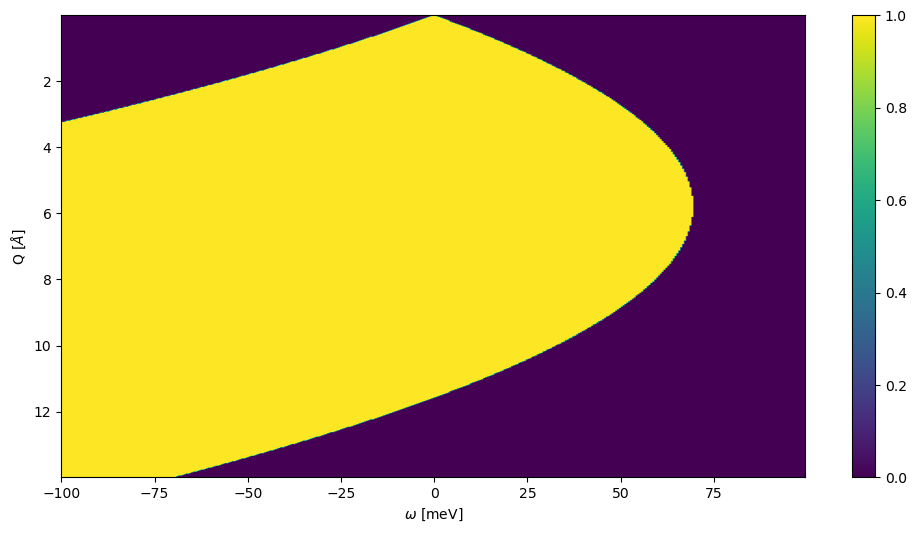

In [316]:
# usage example
out = (Q_mesh>Q_lowlim(ki)) & (Q_mesh<Q_uplim(ki))

# plot
plt.figure(figsize=(12,6))
plt.imshow(out, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

## dQ-$d\theta$ relation

$$ a = 2-\omega/E_i \hspace{2cm} b=2\sqrt{1-\omega/E_i} $$
$$ \Rightarrow dQ = k_i^2/2 \frac{b \sin{\theta}}{\sqrt{a-b\cos{\theta}}} d\theta

In [170]:
##############################
##### dQ-dtheta relation #####
##############################

def dqdtheta(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))

def dthetadq(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return (ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta)))**-1

/tmp/ipykernel_47480/1571942548.py:4: RuntimeWarning: invalid value encountered in divide
  return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))
/tmp/ipykernel_47480/1571942548.py:3: RuntimeWarning: invalid value encountered in sqrt
  b = 2*np.sqrt(1-omega/k2E(ki))


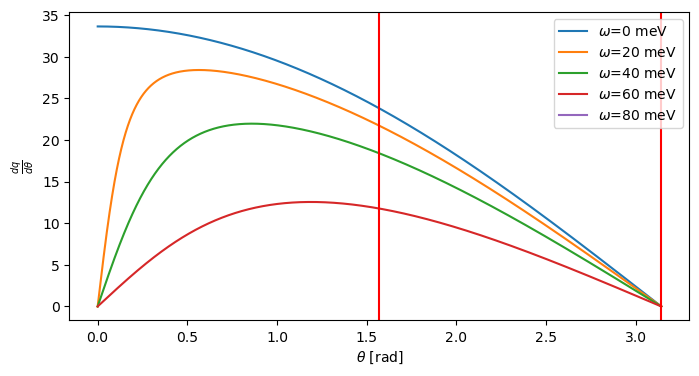

In [330]:
# plot
X = np.linspace(0, np.pi, 10000)

plt.figure(figsize=(8,4))
plt.plot(X, dqdtheta(0, ki, X), label='$\omega$=0 meV')
plt.plot(X, dqdtheta(20, ki, X), label='$\omega$=20 meV')
plt.plot(X, dqdtheta(40, ki, X), label='$\omega$=40 meV')
plt.plot(X, dqdtheta(60, ki, X), label='$\omega$=60 meV')
plt.plot(X, dqdtheta(80, ki, X), label='$\omega$=80 meV')

plt.axvline(np.pi, c='red')
plt.axvline(np.pi/2, c='red')

plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\frac{dq}{d\theta}$')
plt.legend()

## Cut of S(Q, $\omega$) for $k_i$

In [323]:
####################################
##### Cut of the S(Q,w) for Ei #####
####################################
# than normalized (in Q)

S_mesh_cutEi = ((Q_mesh>Q_lowlim(ki)) & (Q_mesh<Q_uplim(ki))) * S_mesh
S_mesh_cutEi /= S_mesh_cutEi.sum() * dQ_vec*domega_vec

/tmp/ipykernel_47480/3552274237.py:1: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) - 2*np.sqrt(1 - omega_vec/k2E(ki)))
/tmp/ipykernel_47480/3552274237.py:3: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim  = lambda ki: ki * np.sqrt(2 - omega_vec/k2E(ki) + 2*np.sqrt(1 - omega_vec/k2E(ki)))


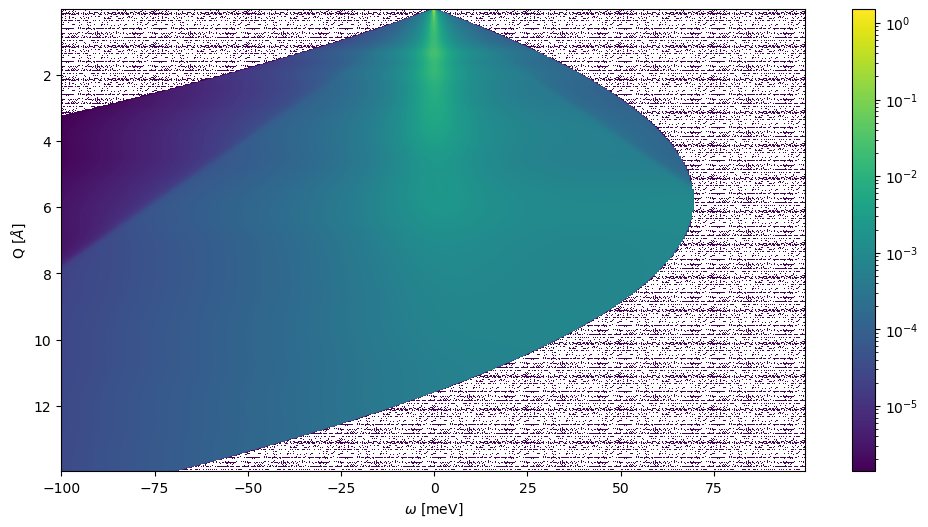

In [325]:
# plot
plt.figure(figsize=(12,6))
plt.imshow(S_mesh_cutEi, aspect='auto', norm='log', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

## Lamber-Beer law

In [324]:
###########################
##### Lamber-Beer law #####
###########################

# Trasmission
T = lambda d: np.exp(-mu_s*d)

# Random scattering extraction from Lamber-Beer law
rand_LB = lambda b: truncexpon.rvs(b = b*mu_s)/mu_s

# The simulation

## Randomly generate N neutrons at x=-d_a2c, random z = [-h/2, h/2] and y[-r, r]

In [175]:
##########################
##### THE SIMULATION #####
##########################

##### RANDOMLY GENERATE N NEUTRONS #####
# from uniform beam at x=-d_a2c, random z = [-h/2, h/2] and y[-r, r]

p0 = np.array([[-d_a2c]*N, rand(N) * 2*r - r, rand(N) * h - h/2]).T
k0 = np.array([[ki, 0, 0]]*N)
w0 = np.array([1]*N)

Text(0.5, 0, 'z0 [cm]')

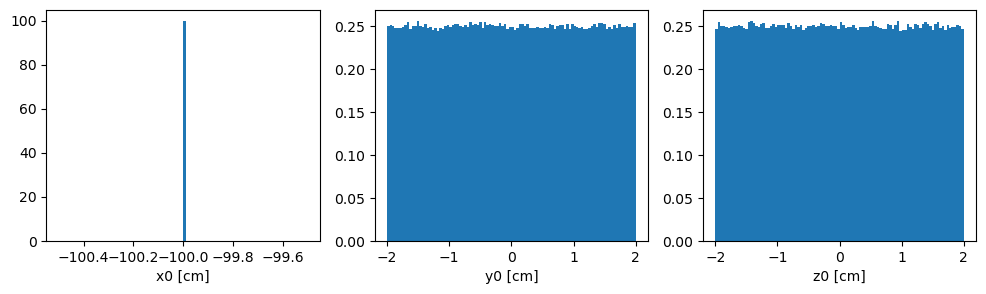

In [327]:
# plots
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.hist(p0[:,0], bins=100, density=True);
plt.xlabel('x0 [cm]')
plt.subplot(1,3,2)
plt.hist(p0[:,1], bins=100, density=True);
plt.xlabel('y0 [cm]')
plt.subplot(1,3,3)
plt.hist(p0[:,2], bins=100, density=True);
plt.xlabel('z0 [cm]')

In [177]:
# dimensions of the vectors
print('p0:', p0.nbytes/1e6, 'MB')
print('k0:', k0.nbytes/1e6, 'MB')
print('w0:', w0.nbytes/1e6, 'MB')

p0: 24.0 MB
k0: 24.0 MB
w0: 8.0 MB


## Extract the scattering positions

In [178]:
### EXTRACT THE 1st SCATTERING EVENT ###

# intercept calculation
ts = CylLine_inter_fromout(p0, k0)
t1, t2 = ts[:,0], ts[:,1]
del ts

d1 = t2 - t1

# trasmission calc and weight update (w1, T1)
T1 = T(d1)
w1 = w0 * (1-T1)

# event position extraction (p1)
dtp1 = rand_LB(d1)
p1 = line_param(t1+dtp1, p0, k0)
del t1, t2, dtp1

Text(0, 0.5, 'y [cm]')

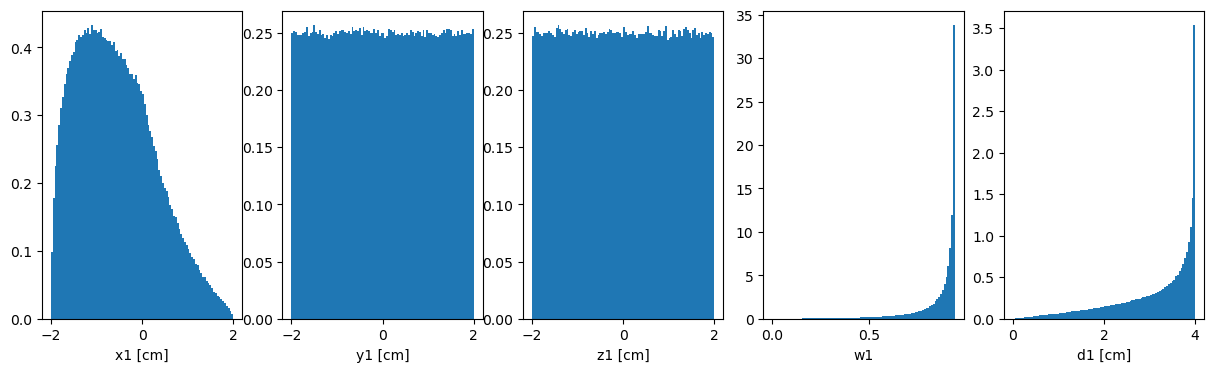

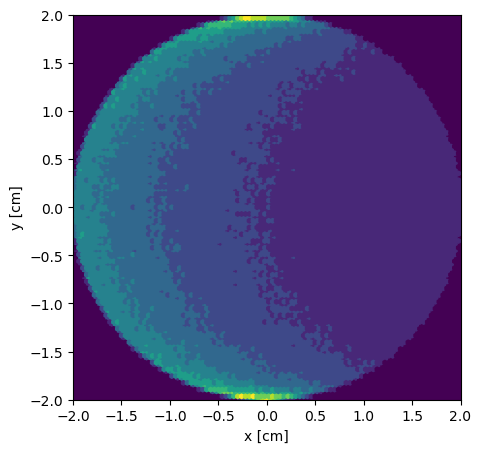

In [331]:
# plots
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,5,1)
plt.hist(p1[:,0], bins=100, density=True);
plt.xlabel('x1 [cm]')
plt.subplot(1,5,2)
plt.hist(p1[:,1], bins=100, density=True);
plt.xlabel('y1 [cm]')
plt.subplot(1,5,3)
plt.hist(p1[:,2], bins=100, density=True);
plt.xlabel('z1 [cm]')
plt.subplot(1,5,4)
plt.hist(w1, bins=100, density=True);
plt.xlabel('w1')
plt.subplot(1,5,5)
plt.hist(d1, bins=100, density=True);
plt.xlabel('d1 [cm]')

# heatmap
plt.figure(figsize=(5,5))
plt.hexbin(p1[:,0], p1[:,1], bins=10);
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

In [332]:
# dimensions of the vectors
print('p1:', p1.nbytes/1e6, 'MB')
print('w1:', w1.nbytes/1e6, 'MB')

p1: 24.0 MB
w1: 8.0 MB


## Probability of single scattering

### Find k1 and omega1 imposing collimator angle

In [374]:
### PROBABILITY OF SINGLE SCATTERING ###

# Find k1, omega1, Q1 imposing collimator angle
k1s = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
Q1s = np.linalg.norm(k0 - k1s, axis=1)
omega1s = (Ei - Ef) * np.ones(N)
theta1s = theta

### Scattering probability from the PDF

$$ P(Q,\omega) = S(Q,\omega) d\omega dQ = S(Q,\omega) d\omega \frac{dQ}{d\theta} d\theta $$

In [375]:
# Get the scattering probavilities from S_mesh_cutEi (w1s)
Q_idx = np.searchsorted(Q_vec, Q1s)
omega_idx = np.searchsorted(omega_vec, omega1s)

w1s = w1 * S_mesh_cutEi[Q_idx, omega_idx] * dqdtheta(omega1s, ki, theta1s) * dtheta * dphi * domega

### Single scattering intercept and trasmission


In [376]:
# Trasmission probability from p0 to detector
t1 = CylLine_inter_fromin(p1, k1s)
T1s = T(t1)

wfs = w1s*T1s

## Multiple scattering path

### Extraction from the S(Q, omega)

/tmp/ipykernel_47480/174824010.py:7: RuntimeWarning: invalid value encountered in sqrt
  Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))
/tmp/ipykernel_47480/174824010.py:7: RuntimeWarning: invalid value encountered in arccos
  Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))
/tmp/ipykernel_47480/1571942548.py:3: RuntimeWarning: invalid value encountered in sqrt
  b = 2*np.sqrt(1-omega/k2E(ki))


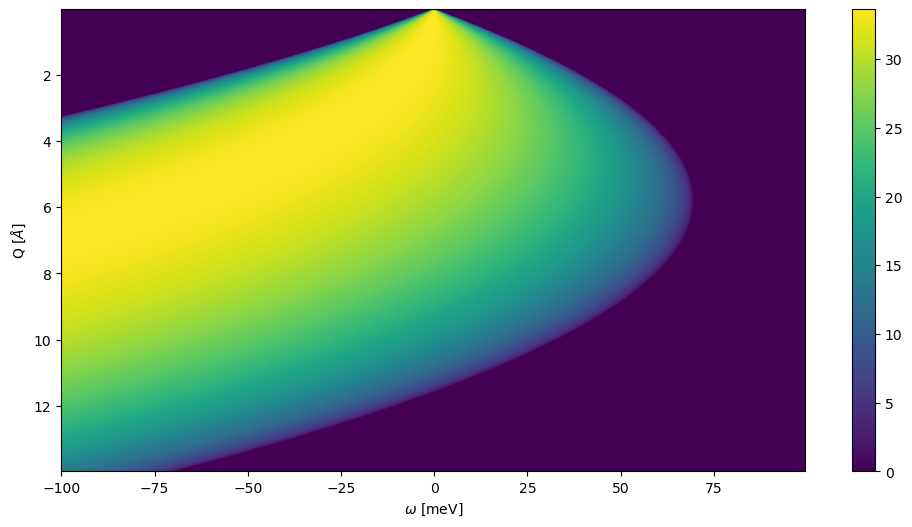

In [377]:
# dQdtheta on the mesh
dQdtheta_pdf = np.nan_to_num(dqdtheta(omega_mesh, ki, Q2theta(omega_mesh, ki, Q_mesh)))
#dthetadQ_pdf = np.nan_to_num(dthetadq(omega_mesh, ki, Q2theta(omega_mesh, ki, Q_mesh)))

plt.figure(figsize=(12,6))
plt.imshow(dQdtheta_pdf, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()

In [378]:
PDF = S_mesh * dQdtheta_pdf # * dtheta * domega
PDF /= PDF.sum() # * dtheta * domega

In [379]:
is_mesh = np.random.choice(np.arange(PDF.shape[0]*PDF.shape[1]), p=PDF.reshape(-1), size=N)
Q1m = Q_mesh.reshape(-1)[is_mesh]
omega1m = omega_mesh.reshape(-1)[is_mesh]
theta1m = Q2theta(omega1m, ki, Q1m)
E1m = Ei - omega1m
w1m = w1

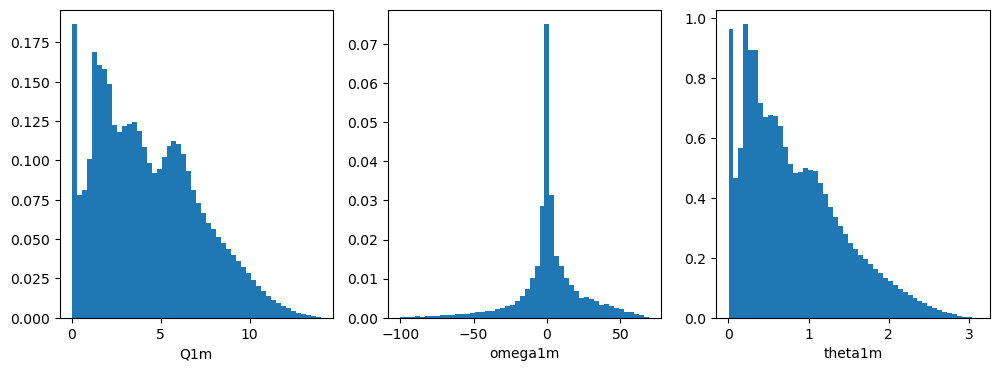

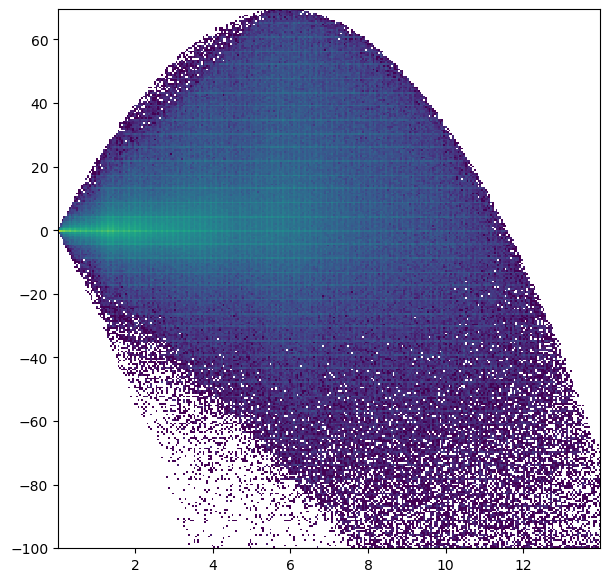

In [371]:
# PLOT
# do this 3d
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(Q1m, bins=50, density=True);
plt.xlabel('Q1m')
plt.subplot(1,3,2)
plt.hist(omega1m, bins=50, density=True);
plt.xlabel('omega1m')
plt.subplot(1,3,3)
plt.hist(theta1m, bins=50, density=True);
plt.xlabel('theta1m')

plt.figure(figsize=(7,7))
plt.hist2d(Q1m, omega1m, bins=300, norm=colors.LogNorm());

### Creation of the scattering vector

In [189]:
phi1m = rand(N)*2*np.pi

In [190]:
k1m = (np.array((np.cos(theta1m), np.cos(phi1m), np.sin(theta1m)*np.sin(phi1m))) * E2k(E1m)).T

### Extract a scattering position for multiple

In [191]:
ts = CylLine_inter_fromin(p1, k1m)
d2 = ts

T2 = T(d2)

w2m = w1m * (1-T2)

dtp2 = rand_LB(d2)
p2 = line_param(dtp2, p1, k1m)
del ts, dtp2

### Find k1 and omega1 imposing collimator angle

In [201]:
k2m = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))

Q2m = np.linalg.norm(k1m - k2m, axis=1)
omega2m = (E1m - Ef) * np.ones(N)

k2m_mod = E2k(E1m) 
theta2m = Q2theta(omega2m, k2m_mod, Q2m)

/tmp/ipykernel_47480/174824010.py:7: RuntimeWarning: invalid value encountered in arccos
  Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))


In [193]:
mask2m = ~((Q2m>Q_vec.max()) | (Q2m<Q_vec.min()) | (omega2m>omega_vec.max()) | (omega2m<omega_vec.min()))

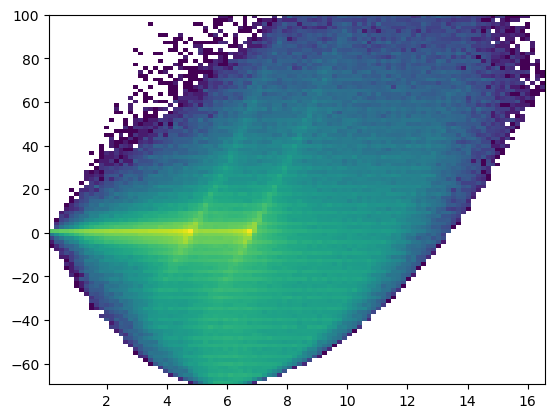

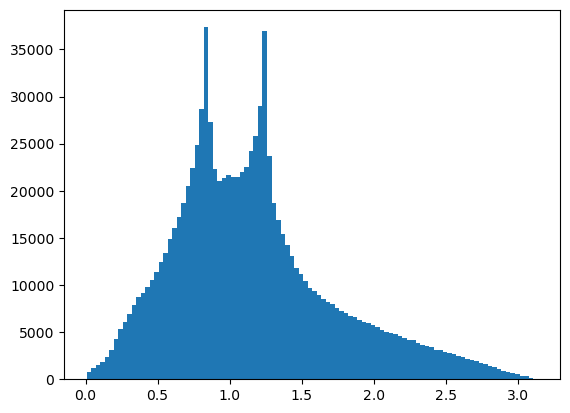

In [204]:
plt.hist2d(Q2m, omega2m, bins=100, norm=colors.LogNorm());
plt.figure()
plt.hist(theta2m, bins = 100);

### Scattering probability from the PDF

In [195]:
Q_idx = np.searchsorted(Q_vec, Q2m)
omega_idx = np.searchsorted(omega_vec, omega2m)

In [ ]:
#N = 100
P = np.zeros(N)
for n in range(10):
    if mask2m[n]:
        S_mesh_cut = ((Q_mesh>Q_lowlim(omega_vec, k2m_mod[n])) & (Q_mesh<Q_uplim(omega_vec, k2m_mod[n]))) * S_mesh
        S_mesh_cut /= S_mesh_cut.sum() * dQ_vec * domega_vec

        P[n] = S_mesh_cut[Q_idx[n], omega_idx[n]]


/tmp/ipykernel_47480/4164127054.py:1: RuntimeWarning: invalid value encountered in sqrt
  Q_lowlim = lambda omega, ki: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki)))
/tmp/ipykernel_47480/4164127054.py:2: RuntimeWarning: invalid value encountered in sqrt
  Q_uplim = lambda omega, ki: ki * np.sqrt(2 - omega/k2E(ki) + 2*np.sqrt(1 - omega/k2E(ki)))
